# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [7]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic
from Timer import Timer

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [8]:
import pytest
from ipytest import run_pytest, clean_tests

In [9]:
%setup_logging
%cuda_context_handler context

Global logger already initialized!
Registering context in user workspace
Context already registered! Ignoring


In [10]:
cuda_kernel = """
__global__ void matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x;
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");
#float* c, float* A, float* b, int a_rows, int a_cols
kernel.prepare('PPPii')

In [11]:
def gpuMatrixVector_async(a, b):
    #create a stream of operations on GPU
    stream = cuda_driver.Stream()
    #context.synchronize()
        
        
    #Upload data to the device
    #NOTE: We need to make sure that a=(a_rows, a_columns)
    # and that b=(a_colmuns, 1) (column vector)
    # and that c=(a_rows, 1)
    with Timer("Data allocation") as t:
        a_g = GPUArray(a.shape, np.float32)
        b_g = GPUArray(b.shape, np.float32)
        c_g = GPUArray(a.shape[0], np.float32)
        #context.synchronize()
        
    with Timer("A upload") as t:
        a_g.set_async(a,stream=stream)
        #context.synchronize()
        
    with Timer("b upload") as t:
        b_g.set_async(b,stream=stream)
        #context.synchronize()
    
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (256, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / block_size[0])), 1, 1)

    #print("Block size is " + str(block_size))
    #print("Grid size is " + str(grid_size))
    
    #Execute program on device
    with Timer("Kernel execution") as t:
        kernel.prepared_async_call(grid_size,block_size,stream,\
                                   c_g.gpudata, a_g.gpudata, b_g.gpudata, \
                                   np.int32(a.shape[0]), np.int32(a.shape[1]))
        #context.synchronize()

    #Copy data from device to host
    with Timer("Allocate c") as t:
        c = np.empty((a.shape[0], 1), dtype=np.float32)
    with Timer("Download") as t:
        c_g.get(c)
        #context.synchronize()
    
    #Return our computed matrix-vector product
    return c

In [12]:
#Size of our test
test_size = (2048,2048)

#Create test input / output data
with Timer("Create test data") as t:
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
with Timer("Run whole function") as t:
    c = gpuMatrixVector_async(a, b)
times[i] = t.msecs


Create test data: 97.867727 ms
Data allocation: 0.799894 ms
A upload: 6.119967 ms
b upload: 0.375032 ms
Kernel execution: 0.101089 ms
Allocate c: 0.011444 ms
/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/ipykernel/__main__.py:43: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Download: 4.055977 ms
Run whole function: 19.119978 ms


NameError: name 'times' is not defined

Synchronisation

On a virer les synchro
```
Create test data: 99.756002 ms
Data allocation: 0.729561 ms
A upload: 6.402254 ms
b upload: 0.203848 ms
Kernel execution: 0.093699 ms
Allocate c: 0.012159 ms
/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/ipykernel/__main__.py:43: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Download: 3.669262 ms
Run whole function: 19.295216 ms
```

In [13]:
def gpuMatrixVector_nosync(a, b):
    #create a stream of operations on GPU
    stream = cuda_driver.Stream()
    #context.synchronize()
        
        
    #Upload data to the device
    #NOTE: We need to make sure that a=(a_rows, a_columns)
    # and that b=(a_colmuns, 1) (column vector)
    # and that c=(a_rows, 1)
    with Timer("Data allocation") as t:
        a_g = GPUArray(a.shape, np.float32)
        b_g = GPUArray(b.shape, np.float32)
        c_g = GPUArray(a.shape[0], np.float32)
        #context.synchronize()
        
    with Timer("A upload") as t:
        a_g.set(a)
        #context.synchronize()
        
    with Timer("b upload") as t:
        b_g.set(b)
        #context.synchronize()
    
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (256, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / block_size[0])), 1, 1)

    #print("Block size is " + str(block_size))
    #print("Grid size is " + str(grid_size))
    
    #Execute program on device
    with Timer("Kernel execution") as t:
        kernel.prepared_async_call(grid_size,block_size,stream,\
                                   c_g.gpudata, a_g.gpudata, b_g.gpudata, \
                                   np.int32(a.shape[0]), np.int32(a.shape[1]))
        #context.synchronize()

    #Copy data from device to host
    with Timer("Allocate c") as t:
        c = np.empty((a.shape[0], 1), dtype=np.float32)
    with Timer("Download") as t:
        c_g.get(c)
        #context.synchronize()
    
    #Return our computed matrix-vector product
    return c

In [14]:
#Size of our test
test_size = (2048,2048)

#Create test input / output data
with Timer("Create test data") as t:
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
with Timer("Run whole function") as t:
    c = gpuMatrixVector_nosync(a, b)
times[i] = t.msecs

Create test data: 102.025986 ms
Data allocation: 0.799179 ms
A upload: 6.199360 ms
b upload: 0.387907 ms
Kernel execution: 0.086784 ms
Allocate c: 0.013590 ms
/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/ipykernel/__main__.py:43: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Download: 3.982544 ms
Run whole function: 19.251585 ms


NameError: name 'times' is not defined

In [15]:
def gpuMatrixVector_sync(a, b):
    #create a stream of operations on GPU
    stream = cuda_driver.Stream()
    context.synchronize()
        
        
    #Upload data to the device
    #NOTE: We need to make sure that a=(a_rows, a_columns)
    # and that b=(a_colmuns, 1) (column vector)
    # and that c=(a_rows, 1)
    with Timer("Data allocation") as t:
        a_g = GPUArray(a.shape, np.float32)
        b_g = GPUArray(b.shape, np.float32)
        c_g = GPUArray(a.shape[0], np.float32)
        context.synchronize()
        
    with Timer("A upload") as t:
        a_g.set(a)
        context.synchronize()
        
    with Timer("b upload") as t:
        b_g.set(b)
        context.synchronize()
    
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (256, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(a.shape[0] / block_size[0])), 1, 1)

    #print("Block size is " + str(block_size))
    #print("Grid size is " + str(grid_size))
    
    #Execute program on device
    with Timer("Kernel execution") as t:
        kernel.prepared_async_call(grid_size,block_size,stream,\
                                   c_g.gpudata, a_g.gpudata, b_g.gpudata, \
                                   np.int32(a.shape[0]), np.int32(a.shape[1]))
        context.synchronize()

    #Copy data from device to host
    with Timer("Allocate c") as t:
        c = np.empty((a.shape[0], 1), dtype=np.float32)
    with Timer("Download") as t:
        c_g.get(c)
        context.synchronize()
    
    #Return our computed matrix-vector product
    return c

In [16]:
#Size of our test
test_size = (2048,2048)

#Create test input / output data
with Timer("Create test data") as t:
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
with Timer("Run whole function") as t:
    c = gpuMatrixVector_sync(a, b)
times[i] = t.msecs

Create test data: 101.673841 ms
Data allocation: 0.821829 ms
A upload: 6.522894 ms
b upload: 0.824213 ms
Kernel execution: 6.147623 ms
Allocate c: 0.015497 ms
/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/ipykernel/__main__.py:43: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Download: 0.314713 ms
Run whole function: 22.640944 ms


NameError: name 'times' is not defined

#Before synchronisation
```
Create test data: 97.065926 ms
Data allocation: 0.797749 ms
A upload: 11.585474 ms
b upload: 0.703812 ms
Kernel execution: 5.970716 ms
Allocate c: 0.014067 ms
/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/ipykernel/__main__.py:43: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Download: 1.465082 ms
Run whole function: 25.820971 ms
```

In [6]:
nx = np.array([200, 400, 800, 1600, 3200, 6400, 8000, 10000])
ny = nx

print(nx, ny)

[  200   400   800  1600  3200  6400  8000 10000] [  200   400   800  1600  3200  6400  8000 10000]


In [7]:
times = np.empty_like(nx)
for i in range(len(nx)):
    print("Nx = " + str(nx[i]), flush=True)
    #Size of our test
    test_size = (nx[i], ny[i])

    #Create test input / output data
    with Timer("Create test data") as t:
        a = np.random.random(test_size).astype(np.float32)
        b = np.random.random((test_size[1], 1)).astype(np.float32)
    with Timer("Run whole function") as t:
        c = gpuMatrixVector(a, b)
    times[i] = t.msecs
    
print(nx*ny)
print(times)
    
    

"""fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()"""

Nx = 200


Create test data: 1.783133 ms
Data allocation: 1.528740 ms
A upload: 1.235723 ms
b upload: 0.769377 ms
Kernel execution: 3.359795 ms
Allocate c: 0.017643 ms
/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/ipykernel/__main__.py:39: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
Download: 2.933264 ms
Run whole function: 19.097567 ms


Nx = 400


Create test data: 4.878044 ms
Data allocation: 0.947237 ms
A upload: 1.768589 ms
b upload: 0.976801 ms
Kernel execution: 0.940323 ms
Allocate c: 0.015974 ms
Download: 0.257969 ms
Run whole function: 12.454271 ms


Nx = 800


Create test data: 16.592979 ms
Data allocation: 1.572609 ms
A upload: 1.882792 ms
b upload: 1.022816 ms
Kernel execution: 1.345873 ms
Allocate c: 0.014305 ms
Download: 0.175714 ms
Run whole function: 12.216330 ms


Nx = 1600


Create test data: 48.404455 ms
Data allocation: 0.941515 ms
A upload: 6.679535 ms
b upload: 0.646353 ms
Kernel execution: 3.712654 ms
Allocate c: 0.011444 ms
Download: 1.129627 ms
Run whole function: 18.537998 ms


Nx = 3200


Create test data: 169.073820 ms
Data allocation: 1.115561 ms
A upload: 26.330709 ms
b upload: 0.886202 ms
Kernel execution: 14.778852 ms
Allocate c: 0.017166 ms
Download: 0.391006 ms
Run whole function: 49.223185 ms


Nx = 6400


Create test data: 672.588587 ms
Data allocation: 1.054049 ms
A upload: 99.964142 ms
b upload: 0.756025 ms
Kernel execution: 77.190638 ms
Allocate c: 0.015020 ms
Download: 0.309229 ms
Run whole function: 184.407949 ms


Nx = 8000


Create test data: 834.132433 ms
Data allocation: 1.963377 ms
A upload: 155.528545 ms
b upload: 0.817299 ms
Kernel execution: 116.661072 ms
Allocate c: 0.017166 ms
Download: 0.195265 ms
Run whole function: 280.435562 ms


Nx = 10000


Create test data: 1301.924229 ms
Data allocation: 1.302004 ms
A upload: 242.333889 ms
b upload: 0.570536 ms
Kernel execution: 197.591782 ms
Allocate c: 0.014305 ms
Download: 0.635624 ms
Run whole function: 448.789597 ms


[    40000    160000    640000   2560000  10240000  40960000  64000000
 100000000]
[ 19  12  12  18  49 184 280 448]


'fig = plt.figure()\nplt.subplot(1,3,1)\nplt.imshow(a)\nplt.subplot(1,3,2)\nplt.imshow(b)\nplt.subplot(1,3,3)\nplt.imshow(c)\nfig.show()'

update_title_pos
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
update_title_pos
update_title_pos
update_title_pos
update_title_pos


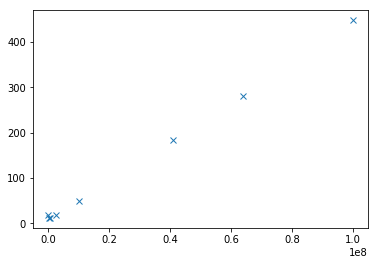

In [8]:
plt.figure()
plt.plot(nx*ny, times, 'x')

In [9]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Sum of absolute differences
sad = np.sum(np.abs(c - c_ref))

#Print result
# print("C   = ", c)
# print("Ref = ", c_ref)
print("Sad = %.30f" % sad)
print("Per element error: " + str(sad / test_size[1]))

Sad = 31.025146484375000000000000000000
Per element error: 0.0031025146484375


In [11]:
clean_tests()

def test_gpuMatrixVector():
    #Let us test a matrix of size 1x1
    a = np.ones((1, 1), dtype=np.float32)
    b = 2*np.ones((1, 1), dtype=np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(2.0)
    
    #Test that the inner product works
    a = np.ones((1, 2), dtype=np.float32)
    b = 2*np.ones((2, 1), dtype=np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(4.0)
    
    #Test a general matrix
    test_size = (4, 3)
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
    c = gpuMatrixVector(a, b)
    assert c == pytest.approx(a.dot(b), rel=1e-3)
    
run_pytest(filename='MatrixVectorTestingSingle.ipynb', pytest_options=['-vvv'])

============================= test session starts ==============================
platform linux -- Python 3.6.6, pytest-3.8.2, py-1.6.0, pluggy-0.7.1 -- /home/jobic/anaconda3/envs/gpudev/bin/python
cachedir: .pytest_cache
rootdir: /home/jobic/test/cuda/milan2018/MilanoGPU2018/andre, inifile:
collecting ... collected 1 item

MatrixVectorTestingSingle.py::test_gpuMatrixVector <- <ipython-input-11-8148f6c0c3df> 

Data allocation: 0.986576 ms
A upload: 0.781059 ms
b upload: 0.773907 ms
Kernel execution: 0.727415 ms
Allocate c: 0.013828 ms
Download: 1.101732 ms
Data allocation: 0.579834 ms
A upload: 0.574589 ms
b upload: 0.629187 ms
Kernel execution: 0.545502 ms
Allocate c: 0.012398 ms
Download: 0.813961 ms
Data allocation: 0.558138 ms
A upload: 0.458956 ms
b upload: 0.442028 ms
Kernel execution: 0.449419 ms
Allocate c: 0.011921 ms
Download: 0.241756 ms


PASSED [100%]

=============================== warnings summary ===============================
/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/ipykernel/__main__.py:39: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/ipykernel/__main__.py:39: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x
/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/ipykernel/__main__.py:39: DeprecationWarning: get() between arrays of different shape is deprecated and will be removed in PyCUDA 2017.x

-- Docs: https://docs.pytest.org/en/latest/warnings.html
===================== 1 passed, 3 warnings in 0.12 seconds =====================


0